# Setup and utils

In [1]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import json, copy
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from types import SimpleNamespace
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
from scipy.interpolate import griddata
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------ MODEL UTILS ----------------------------------------------
class CustomCNN(nn.Module):
    def __init__(self, input_dim, output_dim, depth, num_channels, hidden_dim_lin, activation_function, kernel_size, use_pooling=True):
        super(CustomCNN, self).__init__()

        # Initial number of input channels, assuming grayscale images
        in_channels = 1

        # Dynamically add convolutional and activation layers based on the specified depth
        for i in range(depth):
            # Create a convolutional layer and add it to the model
            setattr(self, f"conv{i}", nn.Conv2d(in_channels, num_channels, kernel_size=kernel_size, padding=math.floor(kernel_size/2)))

            # Create an activation layer (e.g., ReLU) and add it to the model
            setattr(self, f"act{i}", activation_function())

            # Update the input dimensions after convolution
            input_dim = (input_dim - kernel_size + 2 * math.floor(kernel_size/2)) + 1

            # Optionally add pooling layers to reduce spatial dimensions
            if use_pooling and (i+1) % depth == 0:
                setattr(self, f"pool{i}", nn.MaxPool2d(2))
                input_dim = input_dim // 2

            # Update the input channels for the next convolutional layer
            in_channels = num_channels

        # Compute the size of the flattened features for the fully connected layer
        flattened_size = in_channels * input_dim * input_dim
        # Add two fully connected layers for classification
        self.fc_1 = nn.Linear(flattened_size, hidden_dim_lin)
        self.relu = activation_function()
        self.fc_2 = nn.Linear(hidden_dim_lin, output_dim)

        # Add log softmax layer for multi-class classification output
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Iterate over each module in the CustomCNN class
        for layer_name, layer in self.named_children():
            # Process the input tensor through convolutional and activation layers
            if "conv" in layer_name or "act" in layer_name:
                x = layer(x)
            # Process the input tensor through pooling layers if they exist
            elif "pool" in layer_name:
                x = layer(x)
            # If reached fully connected layers, break the loop
            elif isinstance(layer, nn.Linear):
                break

        # Flatten the tensor to fit the input shape of the fully connected layers
        x = x.view(x.size(0), -1)
        # Pass the tensor through the fully connected layers
        x = self.fc_1(x)
        x = self.relu(x)
        x = self.fc_2(x)

        # Return log softmax activated output
        return self.logsoftmax(x)

def generate_cnn(input_dim, output_dim, depth, num_channels, hidden_dim_lin, kernel_size, activation_function=nn.ReLU, use_pooling=True):
    model = CustomCNN(input_dim, output_dim, depth, num_channels, hidden_dim_lin, activation_function, kernel_size, use_pooling)
    return model

class Trainer:
    """
    A class for training and evaluating a model with early stopping and best model saving functionalities.

    Attributes:
    - model: PyTorch model to be trained and evaluated.
    - dataloader: Contains data loaders (train, validation, test) for training and evaluation.
    - params: Dictionary containing various hyperparameters and settings.
    - device: the device to which tensors should be moved before computation.
    - optimizer: The optimizer for training.
    - best_model_state: State dictionary of the best model.
    - max_val_acc: The highest validation accuracy encountered during training.
    - no_improve_epochs: Number of epochs without improvement in validation accuracy.
    - is_cnn: Flag indicating if the model is a CNN.
    - is_debug: Flag indicating if debug information should be printed.
    - classification_report_flag: Flag indicating if a classification report should be generated.

    Methods:
    - train_epoch(): Runs a single epoch of training.
    - evaluate(loader): Evaluates the model on a given data loader.
    - save_best_model(): Saves the current state of the model as the best model.
    - save_checkpoint(epoch, train_acc, val_acc): Saves the current state of the model and other information as a checkpoint.
    - early_stopping_check(val_acc): Checks the stopping criterion and performs actions based on it.
    - train(): Runs the training process for a number of epochs, with early stopping functionality.

    Usage:
    params = {
      'device': 'cuda',
      'lr': 0.001,
      'num_train': 10,
      'early_stop_patience': 3,
      'save_best': True,
      'save_checkpoints': False,
      'is_cnn': True,
      'is_debug': True,
      'classification_report_flag': True
    }

    trainer = Trainer(model, dataloader, params)
    train_acc, test_acc, effective_epochs, checkpoints = trainer.train()
    """
    def __init__(self, model, dataloader, lr, params):
        self.model = model
        self.dataloader = dataloader
        self.params = params
        self.device = torch.device(params['device'])
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        # optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        # Initialize best_model_state with the current model state
        self.best_model_state = copy.deepcopy(self.model.state_dict())
        self.max_val_acc = 0.
        self.no_improve_epochs = 0
        self.is_cnn = params.get('is_cnn', False)
        self.is_debug = params.get('is_debug', False)
        self.classification_report_flag = params.get('classification_report_flag', False)
        self.logger = params.get('logger', print)

    def train_epoch(self):
      self.model.train()
      for batch_idx, (data, target) in enumerate(self.dataloader.train_loader):
          # Print the size of the current batch
          if self.is_cnn:
            data = data.view(data.size(0), 1, 28, 28)
          else:
            data = data.reshape([data.shape[0], -1])
          data, target = data.to(self.device), target.to(self.device)
          self.optimizer.zero_grad()
          output = self.model(data)
          loss = F.nll_loss(output, target)
          loss.backward()
          self.optimizer.step()

          if self.is_debug and batch_idx % 20 == 0:
              self.logger(f"Batch: {batch_idx}, Loss: {loss.item()}")

    def evaluate(self, loader):
        return eval(self.model, self.device, loader, self.is_debug, self.classification_report_flag, self.is_cnn)

    def save_best_model(self):
        torch.save(self.model.state_dict(), 'best_model.pth')

    def save_checkpoint(self, epoch, train_acc, val_acc):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_acc': train_acc,
            'val_acc': val_acc
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pth')
        return checkpoint

    def early_stopping_check(self, val_acc):
        if val_acc > self.max_val_acc:
            self.max_val_acc = val_acc
            self.no_improve_epochs = 0
            # Deep copy the model's state
            self.best_model_state = copy.deepcopy(self.model.state_dict())
            if self.params.get('save_best', False):
                self.save_best_model()
        else:
            self.no_improve_epochs += 1
            if self.no_improve_epochs >= self.params['early_stop_patience']:
                self.logger("Early stopping invoked.")
                # Only load if best_model_state has been set
                if self.best_model_state is not None:
                    self.model.load_state_dict(self.best_model_state)
                return True
        return False

    def train(self, verbose=1):
        effective_epochs = 0
        checkpoints = []

        for epoch in range(self.params['num_train']):
            effective_epochs += 1
            self.train_epoch()

            train_acc = self.evaluate(self.dataloader.train_loader)
            val_acc = self.evaluate(self.dataloader.val_loader)
            if verbose >= 1:
                self.logger(f'Epoch: {epoch} \tTraining Accuracy: {train_acc*100:.2f}%')
                self.logger(f'Validation Accuracy: {val_acc*100:.2f}%')

            if self.params.get('early_stop_patience', None):
                if self.early_stopping_check(val_acc):
                    self.model.load_state_dict(self.best_model_state)
                    break

            if self.params.get('save_checkpoints', False):
                checkpoint = self.save_checkpoint(epoch, train_acc, val_acc)
                checkpoints.append(checkpoint)

        # Final evaluations
        train_acc = self.evaluate(self.dataloader.train_loader)
        test_acc = self.evaluate(self.dataloader.test_loader)

        return train_acc, test_acc, effective_epochs, checkpoints

def eval(model, device, dataset_loader, debug=False, classification_report_flag=False, is_cnn=True, logger=print):
    """
    Evaluates the model on the given dataset loader.

    Parameters:
    - model: the PyTorch model to evaluate.
    - device: the device to which tensors should be moved before computation.
    - dataset_loader: DataLoader for evaluation.
    - debug: whether to print debug info like loss and accuracy.
    - classification_report_flag: whether to print a classification report.
    - is_cnn: a flag indicating if the model is a CNN. If it's not, the input data will be reshaped.
    - logger: logging function for printing messages.

    Returns:
    - Accuracy of the model on the provided dataset loader.

    Usage:
    - accuracy = eval(model, device, dataset_loader, debug=False, is_cnn=False, classification_report_flag=False)
    """

    model.eval()
    test_loss, correct = 0., 0.
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in dataset_loader:
            if is_cnn:
              data = data.view(data.size(0), 1, 28, 28)
            else:
              data = data.reshape([data.shape[0], -1])
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data

    if debug:
        logger('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, num_data, 100. * acc))

    if classification_report_flag:
        unique_labels = np.unique(all_labels).tolist()
        logger(classification_report(all_labels, all_preds, labels=unique_labels, target_names=[f'Class {i}' for i in unique_labels]))

    return acc

def cut_custom_cnn_model(model, cut_point, params):
    """
    Cut the CustomCNN model at a specific layer and reinitialize the weights for layers after cut_point.

    Parameters:
    - model (CustomCNN): Original CustomCNN model.
    - cut_point (int): Layer index (in terms of conv layers) at which to modify the model.
    - freeze (bool): If True, layers before cut_point will have their weights frozen.
    - reinitialize (bool): If True, layers after cut_point will have their weights reinitialized.

    Returns:
    - new_model (CustomCNN): Modified model.
    """

    new_model = copy.deepcopy(model)

    # Get names of layers in the model
    layer_names = list(new_model._modules.keys())

    # Find indices of Conv layers
    conv_indices = [i for i, name in enumerate(layer_names) if 'conv' in name]
    #print(conv_indices)

    # If freeze is True, set requires_grad to False for layers before cut_point
    if params["freeze"]:
        for idx in conv_indices[:cut_point]:
            for param in getattr(new_model, layer_names[idx]).parameters():
                param.requires_grad = False

    # Reinitialize layers after cut_point
    if params["reinit"]:
        for idx in conv_indices[cut_point:]:
            layer = getattr(new_model, layer_names[idx])
            layer.reset_parameters()
            """
            nn.init.kaiming_uniform_(layer.weight, a=0, mode='fan_in', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)
            """

    # if reinit_both_dense: reinit the one before the last one too
    if params["reinit_both_dense"]:
        new_model.fc_1.reset_parameters()

    # reinit the final dense layer anyway
    new_model.fc_2.reset_parameters()
    
    return new_model

# --------------------------------- DATA UTILS -----------------------------------
def reduce_dataset(dataloader, percentage, balanced=True, seed=42):

    """
    Reduces the dataset to the given percentage. Can ensure class balance if needed.

    Parameters:
    - dataloader: PyTorch DataLoader object.
    - percentage: Desired percentage of the original dataset.
    - balanced: If True, ensures class balance. If False, reduces randomly.
    - seed: Seed for reproducibility.

    Returns:
    - reduced_dataloader: DataLoader with the reduced dataset.
    """
    # Extract the dataset from the dataloader
    dataset = dataloader.dataset

    # Extract all data and labels from the dataset
    X = [dataset[i][0] for i in range(len(dataset))]
    y = [dataset[i][1] for i in range(len(dataset))]

    # Set the seed for reproducibility
    torch.manual_seed(seed)

    if not balanced:
        # Determine the number of samples to keep
        num_samples = int(len(dataset) * percentage)

        # Randomly select indices without replacement
        indices = torch.randperm(len(dataset))[:num_samples].tolist()

    else:
        # Get unique classes and their counts
        classes, class_counts = torch.unique(torch.tensor(y), return_counts=True)

        # Determine the number of samples per class to keep
        num_samples_per_class = int(len(dataset) * percentage / len(classes))
        indices = []

        for class_label in classes:
            class_indices = [i for i, label in enumerate(y) if label == class_label]

            # Randomly select indices without replacement for each class
            class_selected_indices = torch.randperm(len(class_indices))[:num_samples_per_class].tolist()
            indices.extend([class_indices[i] for i in class_selected_indices])

    # Use a Subset of the original dataset to create a reduced dataset
    reduced_dataset = data.Subset(dataset, indices)

    # Create a DataLoader with the reduced dataset.
    reduced_dataloader = data.DataLoader(reduced_dataset, batch_size=dataloader.batch_size, shuffle=True)

    return reduced_dataloader

class RelabeledSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, offset):
        self.dataset = dataset
        self.offset = offset

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        # Offset the label to start from 0
        label = label - self.offset
        return data, label

    def __len__(self):
        return len(self.dataset)

class TransferLearningMNIST(object):
    def __init__(self, batch_size, input_dim=28*28, val_split=0.1, num_workers=0, seed=42):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split

        def filter_dataset(dataset, classes):
            indices = [i for i, t in enumerate(dataset.targets) if t in classes]
            return torch.utils.data.Subset(dataset, indices)

        mnist_train_data = datasets.MNIST(
            '../data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_train_data = filter_dataset(mnist_train_data, list(range(5)))
        finetune_train_data = filter_dataset(mnist_train_data, list(range(5, 10)))

        pretrain_len = len(pretrain_train_data)
        finetune_len = len(finetune_train_data)
        pretrain_val_len = int(val_split * pretrain_len)
        finetune_val_len = int(val_split * finetune_len)
        pretrain_train_set, pretrain_val_set = torch.utils.data.random_split(
            pretrain_train_data, [pretrain_len - pretrain_val_len, pretrain_val_len], generator=torch.Generator().manual_seed(seed))
        finetune_train_set, finetune_val_set = torch.utils.data.random_split(
            finetune_train_data, [finetune_len - finetune_val_len, finetune_val_len], generator=torch.Generator().manual_seed(seed))

        self.pretrain_train_loader = torch.utils.data.DataLoader(pretrain_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.pretrain_val_loader = torch.utils.data.DataLoader(pretrain_val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        # Use the RelabeledSubset for fine-tuning datasets
        finetune_train_set = RelabeledSubset(finetune_train_set, 5)
        finetune_val_set = RelabeledSubset(finetune_val_set, 5)

        self.finetune_train_loader = torch.utils.data.DataLoader(finetune_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.finetune_val_loader = torch.utils.data.DataLoader(finetune_val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        mnist_test_data = datasets.MNIST(
            '../data',
            train=False,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_test_data = filter_dataset(mnist_test_data, list(range(5)))
        finetune_test_data = filter_dataset(mnist_test_data, list(range(5, 10)))

        self.pretrain_test_loader = torch.utils.data.DataLoader(pretrain_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        # Use the RelabeledSubset for fine-tuning test datasets
        finetune_test_data = RelabeledSubset(finetune_test_data, 5)
        self.finetune_test_loader = torch.utils.data.DataLoader(finetune_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        # Complete test loader contains all test examples.
        self.complete_test_loader = torch.utils.data.DataLoader(mnist_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

class TransferLearningMNISTWrapper:
    """
    This wrapper class provides a convenient way to switch between pretraining and fine-tuning phases.

    It allows for changing the phase and accordingly updating the data loaders (train, val, test)
    to either pretraining or fine-tuning sets.
    """
    def __init__(self, transferLearningMNISTObj, phase):
        """
        Initializes the TransferLearningMNISTWrapper object.

        Parameters:
        - transferLearningMNISTObj: An instance of the TransferLearningMNIST class.
        - phase: String indicating the current phase ("pretrain" or "finetune").
        """
        self.transferLearningMNISTObj = transferLearningMNISTObj
        self.phase = phase
        self.input_dim = self.transferLearningMNISTObj.input_dim
        self.output_dim = self.transferLearningMNISTObj.output_dim
        self.update_phase(phase)

    def update_phase(self, phase):
        """
        Updates the phase and the corresponding data loaders.

        Parameters:
        - phase: String indicating the desired phase ("pretrain" or "finetune").

        Throws:
        - ValueError: If the phase is neither "pretrain" nor "finetune".
        """
        self.phase = phase
        if phase == 'pretrain':
            self.train_loader = self.transferLearningMNISTObj.pretrain_train_loader
            self.val_loader = self.transferLearningMNISTObj.pretrain_val_loader
            self.test_loader = self.transferLearningMNISTObj.pretrain_test_loader
        elif phase == 'finetune':
            self.train_loader = self.transferLearningMNISTObj.finetune_train_loader
            self.val_loader = self.transferLearningMNISTObj.finetune_val_loader
            self.test_loader = self.transferLearningMNISTObj.finetune_test_loader
        else:
            raise ValueError('Phase must be either "pretrain" or "finetune".')

    def get_current_phase(self):
      return self.phase

# ------------------------------------------ PLOTTING UTILS -------------------------------------------
'''def effective_rank(singular_values):
    sigma_max = np.max(singular_values)
    sigma_min = singular_values[-1] if singular_values[-1] > 0 else np.min(singular_values[singular_values > 0])
    # print(sigma_max, sigma_min)
    print(np.sqrt(sigma_max / sigma_min))
    print('----')
    return np.sqrt(sigma_max / sigma_min)'''

def effective_rank(singular_values):
    normalized_singular_values = singular_values / np.sum(singular_values)
    entropy = -np.sum(normalized_singular_values * np.log(normalized_singular_values))
    eff_rank = np.exp(entropy)
    return eff_rank

def plot_layer_effective_ranks(model, print_ranks=True):
    effective_ranks = []
    layer_names = []

    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            singular_values = np.linalg.svd(weight_matrix, compute_uv=False)
            eff_rank = effective_rank(singular_values)
            effective_ranks.append(eff_rank)
            layer_names.append(name)

    if print_ranks:
        for layer_name, eff_rank in zip(layer_names, effective_ranks):
            print(f'{layer_name}: {eff_rank:.4f}')

    # Plotting
    plt.figure(figsize=(15, 5))
    plt.bar(layer_names, effective_ranks, color='green')
    plt.xlabel('Layer')
    plt.ylabel('Effective Rank')
    plt.title('Effective Rank of Weight Matrices for Each Layer')
    plt.grid(True)

    y_max = np.max(effective_ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(effective_ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(0, int(y_max)+2, step=2))  # Set yticks

    plt.show()

# EXPERIMENT SETUP 1: _FREEZE, REINIT, POOLING, DENSE:REINIT BOTH_
- percentages_set_1 = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]
- dataset: same as before MNIST 5 to 5

- architecture:
  - Conv 1 (5,5), channels=10
  - Relu
  - Conv 2 (5,5), channels=10
  - Relu
  - Conv 3 (5,5), channels=10
  - Relu
  - _POOLING_
  - Dense 1 (x, a) x=output shape of prev layer, a:random hidden layer width (we use 128)
  - Relu
  - Dense 2 (a, 5)
  - softmax

- lr pretraining = 0.001
- lr finetuning = 0.0001
- lr end-to-end = 0.001

- Freezing the layers before the cut: _YES_
- Reinitializing the Convolutional layers after the cut: _YES_
- Reinitializing Dense 1: _YES_
- Reinitializing Dense 2: _YES_


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]
percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1]

# cuts=0 means: end-to-end model if we are reinitializing
cuts = [0,1,2,3]
seed_set = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # currently not being used
batch_size = 4096

## Pretraining



In [4]:
dataloader = TransferLearningMNIST(batch_size)
dataloader_wrapped = TransferLearningMNISTWrapper(dataloader, phase = 'pretrain')

# Changes Here for the experiments
params = {
      'depth': 3,
      'width': 10, # num channels for CNN
      'hidden_dim_lin': 128,
      'activation_function': nn.ReLU,
      'kernel_size': 5,
      'device': device,
      'lr_pretrain': 0.001,   
      'lr_fine_tune': 0.001,  # CHANGE: if no layer-wise lr
      'lr_fine_tune_reinit': 0.001,         # CHANGE: if no layer-wise lr
      'lr_fine_tune_no_reinit': 0.0001,     # CHANGE: if layer-wise lr
      'num_train': 40,
      'early_stop_patience': 6,
      'save_best': False,
      'save_checkpoints': False,
      'is_cnn': True,
      'is_debug': False,
      'classification_report_flag': False,
      'percentages':percentages,
      'batch_size':batch_size,
      'seed_set':seed_set,
      'use_pooling': False,   # CHANGE
      'freeze': True,         # CHANGE: freeze the conv layers before the cut
      'reinit': False,         # CHANGE: reinit the conv lyers only after the cut
      'reinit_both_dense': True   # CHANGE: True for reinitialize both dense layers, False for reinit only the last dense layer
    }

# Create DNN model
pretrained_model = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
                    hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])
pretrained_model.to(device)

CustomCNN(
  (conv0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act0): ReLU()
  (conv1): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): ReLU()
  (conv2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act2): ReLU()
  (fc_1): Linear(in_features=7840, out_features=128, bias=True)
  (relu): ReLU()
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

In [5]:
# # Train and evaluate
# trainer = Trainer(pretrained_model, dataloader_wrapped, params["lr_pretrain"], params)
# train_acc, test_acc, effective_epochs, checkpoints = trainer.train()

# print(f"Final Training Accuracy: {train_acc:.4f}")
# print(f"Final Test Accuracy: {test_acc:.4f}")

Epoch: 0 	Training Accuracy: 35.01%
Validation Accuracy: 34.19%
Epoch: 1 	Training Accuracy: 87.10%
Validation Accuracy: 86.20%
Epoch: 2 	Training Accuracy: 91.90%
Validation Accuracy: 90.91%
Epoch: 3 	Training Accuracy: 93.95%
Validation Accuracy: 93.69%
Epoch: 4 	Training Accuracy: 94.87%
Validation Accuracy: 94.41%
Epoch: 5 	Training Accuracy: 95.69%
Validation Accuracy: 94.80%
Epoch: 6 	Training Accuracy: 95.98%
Validation Accuracy: 95.10%
Epoch: 7 	Training Accuracy: 96.35%
Validation Accuracy: 95.42%
Epoch: 8 	Training Accuracy: 96.44%
Validation Accuracy: 95.42%
Epoch: 9 	Training Accuracy: 96.61%
Validation Accuracy: 95.82%
Epoch: 10 	Training Accuracy: 96.94%
Validation Accuracy: 96.08%
Epoch: 11 	Training Accuracy: 97.20%
Validation Accuracy: 96.47%
Epoch: 12 	Training Accuracy: 97.33%
Validation Accuracy: 96.76%
Epoch: 13 	Training Accuracy: 97.53%
Validation Accuracy: 97.06%
Epoch: 14 	Training Accuracy: 97.64%
Validation Accuracy: 96.89%
Epoch: 15 	Training Accuracy: 97.66

In [11]:
dataloader_wrapped.update_phase('pretrain')

In [12]:
pretrained_model.load_state_dict(torch.load('pretrained_models/pretrained_0.001/pretrained_model_cpu.pth'))
pretrained_model.to(device)

CustomCNN(
  (conv0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act0): ReLU()
  (conv1): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): ReLU()
  (conv2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act2): ReLU()
  (fc_1): Linear(in_features=7840, out_features=128, bias=True)
  (relu): ReLU()
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

In [18]:
from torchviz import make_dot

model = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
                    hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])

x = torch.randn(1, 1, 28, 28)  # Example input (batch size, channels, height, width)
y = model(x)
dot = make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))
dot.render('network_graph', format='png')  # This will save the visualization as 'network_graph.png'


'network_graph.png'

In [7]:
eval(pretrained_model, device, dataloader_wrapped.val_loader, debug=True, classification_report_flag=True, is_cnn=True)


Average loss: 0.0281, Accuracy: 3029.0/3059 (99%)

              precision    recall  f1-score   support

     Class 0       0.99      0.99      0.99       544
     Class 1       1.00      0.99      0.99       670
     Class 2       0.98      0.99      0.98       631
     Class 3       0.99      0.99      0.99       613
     Class 4       1.00      1.00      1.00       601

    accuracy                           0.99      3059
   macro avg       0.99      0.99      0.99      3059
weighted avg       0.99      0.99      0.99      3059



0.990192873488068

In [57]:
# save model for later use
#torch.save(pretrained_model.state_dict(), 'pretrained_models/pretrained_0.001/pretrained_model.pth')


params_tmp = copy.deepcopy(params)
del params_tmp["device"]
params_tmp["activation_function"] = str(params_tmp["activation_function"])
#save params as well
with open('pretrained_models/pretrained_0.001/params.json', 'w') as fp:
    json.dump(params_tmp, fp)

In [72]:
# # deepcopy the pretrained model
# pretrained_model_copy = copy.deepcopy(pretrained_model)
# #send the copy to cpu
# pretrained_model_copy.to(torch.device("cpu"))
# #save the copy
# torch.save(pretrained_model_copy.state_dict(), 'pretrained_models/pretrained_0.001/pretrained_model_cpu.pth')

## Fine-tuning Experiments

In [ ]:
# load results: to continue from a checkpoint (actually don't run)
with open('results.json', 'r') as f:
    results = json.load(f)

### Baselines (skip if it was already run)

In [7]:
from tqdm import tqdm

In [11]:
results = []

In [72]:
#training of baseline, end to end, models (#trials x #percentages)

dataloader_wrapped.update_phase('finetune')

# template_model = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
#                      hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])

for sampled_percentage in tqdm(percentages):      
    if sampled_percentage <= 0.01:
        repeats = 25
    elif sampled_percentage < 0.5:
        repeats = 15
    else:
        repeats = 5
    
    for repeat in range(repeats):
        # Print or log the sampled values for transparency
        print(f"\nSampled Percentage: {sampled_percentage}, Lr: {params['lr_fine_tune']}, Repeat: {repeat}")

        # Reduce the dataset
        train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed = repeat)
        torch.manual_seed(repeat)
        #train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed = repeat)
        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)

        # Copy and then cut the model - we already deepcopy it in the function: pretrained_model
        #model_temp = copy.deepcopy(template_model)
        model_temp = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
        hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])
        model_temp.to(device)

        # Train and evaluate
        trainer = Trainer(model_temp, dataset_namespace_new, params['lr_fine_tune'], params)
        train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
        print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

        # Store the results
        results.append({"lr":params['lr_fine_tune'], "sampled_percentage":sampled_percentage, "sampled_cut_point":-1, "repeat":repeat, "train_acc":train_acc, "test_acc":test_acc}) # -1 for the cut point means it's baseline

  0%|          | 0/3 [00:00<?, ?it/s]


Sampled Percentage: 0.0003, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.4729

Sampled Percentage: 0.0003, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.4995

Sampled Percentage: 0.0003, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.5542

Sampled Percentage: 0.0003, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.5065

Sampled Percentage: 0.0003, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.3429

Sampled Percentage: 0.0003, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.5308

Sampled Percentage: 0.0003, Lr: 0.001, Repeat: 6
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.3847

Sampled Percentage: 0.0003, Lr: 0.001, Repeat: 7
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.5517

Sampled Percent

 33%|███▎      | 1/3 [02:44<05:28, 164.23s/it]

Training Accuracy: 1.0000, Test Accuracy: 0.4250

Sampled Percentage: 0.0005, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.5686

Sampled Percentage: 0.0005, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.5857

Sampled Percentage: 0.0005, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.6750

Sampled Percentage: 0.0005, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.6674

Sampled Percentage: 0.0005, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.4904

Sampled Percentage: 0.0005, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.6071

Sampled Percentage: 0.0005, Lr: 0.001, Repeat: 6
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.4760

Sampled Percentage: 0.0005, Lr: 0.001, Repeat: 7
Early stopping invoked.
Training Accurac

 67%|██████▋   | 2/3 [05:47<02:55, 175.50s/it]

Training Accuracy: 1.0000, Test Accuracy: 0.6383

Sampled Percentage: 0.0007, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.6735

Sampled Percentage: 0.0007, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.6042

Sampled Percentage: 0.0007, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.7243

Sampled Percentage: 0.0007, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.7295

Sampled Percentage: 0.0007, Lr: 0.001, Repeat: 4
Training Accuracy: 1.0000, Test Accuracy: 0.6497

Sampled Percentage: 0.0007, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.6848

Sampled Percentage: 0.0007, Lr: 0.001, Repeat: 6
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.4789

Sampled Percentage: 0.0007, Lr: 0.001, Repeat: 7
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy

100%|██████████| 3/3 [09:09<00:00, 183.13s/it]

Training Accuracy: 1.0000, Test Accuracy: 0.6731


In [18]:
# save baseline results
params_tmp = copy.deepcopy(params)
del params_tmp["device"]
params_tmp["activation_function"] = str(params_tmp["activation_function"])
results = [params_tmp] + results


with open(f'results_jsons/baselines_freeze_{params["freeze"]}_pool_{params["use_pooling"]}_lr_{params["lr_fine_tune"]}_random_subsamples.json', 'w') as f:
    json.dump(results, f)

In [48]:
#load 
with open('results_jsons/baselines_freeze_True_pool_False_lr_0.001_seed_subsamples.json', 'r') as f:
    baseline_results = json.load(f)

#only keep the results for the baseline (cut point = -1)
baseline_results = [result for result in baseline_results[1:] if result["sampled_cut_point"] == -1]


### Fine-tuning

In [50]:
results = baseline_results 

In [69]:
percentages = [0.0003, 0.0005, 0.0007]
#percentages = [0.01, 0.05, 0.1]
#percentages = [0.001, 0.002, 0.005]
#percentages = [0.3]

In [68]:
temp = reduce_dataset(dataloader_wrapped.train_loader, 0.0007, seed=repeat)
#number of samples in the reduced dataset
len(temp.dataset)

15

In [70]:
from tqdm import tqdm

dataloader_wrapped.update_phase('finetune')

# Store results
#results = []
# Store unique combinations that have been tested: we need this if we want to test random combinations
# tested_combinations = set()

# for lr in learning_rates:
#     params["lr"] = lr
# repeating the whole thing with multiple lr and saving the results somewhere
for sampled_percentage in tqdm(percentages):

    if sampled_percentage <= 0.01:
        repeats = 20
    elif sampled_percentage < 0.5:
        repeats = 15
    else:
        repeats = 5
        
    for sampled_cut_point in cuts:

        for repeat in range(repeats):
            # Add the combination to the tested set
            # tested_combinations.add((sampled_percentage, sampled_cut_point))

            # Print or log the sampled values for transparency
            print(f"\nSampled Percentage: {sampled_percentage}, Sampled Cut Point: {sampled_cut_point}, Lr: {params['lr_fine_tune']}, Repeat: {repeat}")

            # Reduce the dataset
            train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed=repeat)
            dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)
            torch.manual_seed(repeat) # because in the cut function we reinitialize some layers too (at least the dense layers)
            
            # Copy and then cut the model - we already deepcopy it in the function: pretrained_model
            model_new = cut_custom_cnn_model(pretrained_model, sampled_cut_point, params)

            # Train and evaluate
            trainer = Trainer(model_new, dataset_namespace_new, params['lr_fine_tune'], params)
            train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
            print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

            # Store the results
            results.append({"lr":params['lr_fine_tune'], "sampled_percentage":sampled_percentage, "sampled_cut_point":sampled_cut_point, "repeat":repeat, "train_acc":train_acc, "test_acc":test_acc})       

  0%|          | 0/3 [00:00<?, ?it/s]


Sampled Percentage: 0.0003, Sampled Cut Point: 0, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.5579

Sampled Percentage: 0.0003, Sampled Cut Point: 0, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.4446

Sampled Percentage: 0.0003, Sampled Cut Point: 0, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.5355

Sampled Percentage: 0.0003, Sampled Cut Point: 0, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.5602

Sampled Percentage: 0.0003, Sampled Cut Point: 0, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.3796

Sampled Percentage: 0.0003, Sampled Cut Point: 0, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.6852

Sampled Percentage: 0.0003, Sampled Cut Point: 0, Lr: 0.001, Repeat: 6
Early stopping invoked.
Training Accuracy: 1.0000, Test Ac

 33%|███▎      | 1/3 [06:47<13:34, 407.01s/it]

Training Accuracy: 1.0000, Test Accuracy: 0.6521

Sampled Percentage: 0.0005, Sampled Cut Point: 0, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.6715

Sampled Percentage: 0.0005, Sampled Cut Point: 0, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.7229

Sampled Percentage: 0.0005, Sampled Cut Point: 0, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.7007

Sampled Percentage: 0.0005, Sampled Cut Point: 0, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.6192

Sampled Percentage: 0.0005, Sampled Cut Point: 0, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.5108

Sampled Percentage: 0.0005, Sampled Cut Point: 0, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.7219

Sampled Percentage: 0.0005, Sampled Cut Point: 0, Lr: 0.001, Repeat: 6
Early sto

 67%|██████▋   | 2/3 [14:36<07:23, 443.95s/it]

Training Accuracy: 1.0000, Test Accuracy: 0.6684

Sampled Percentage: 0.0007, Sampled Cut Point: 0, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.7422

Sampled Percentage: 0.0007, Sampled Cut Point: 0, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.7517

Sampled Percentage: 0.0007, Sampled Cut Point: 0, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.8089

Sampled Percentage: 0.0007, Sampled Cut Point: 0, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.7789

Sampled Percentage: 0.0007, Sampled Cut Point: 0, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.7494

Sampled Percentage: 0.0007, Sampled Cut Point: 0, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.7756

Sampled Percentage: 0.0007, Sampled Cut Point: 0, Lr: 0.001, Repeat: 6
Early sto

100%|██████████| 3/3 [22:31<00:00, 450.48s/it]

Training Accuracy: 1.0000, Test Accuracy: 0.7097


In [84]:
from tqdm import tqdm

percentages = [ 0.05, 0.1]

dataloader_wrapped.update_phase('finetune')

# Store results
#results = []
# Store unique combinations that have been tested: we need this if we want to test random combinations
# tested_combinations = set()

# for lr in learning_rates:
#     params["lr"] = lr
# repeating the whole thing with multiple lr and saving the results somewhere
for sampled_percentage in tqdm(percentages):

    if sampled_percentage <= 0.01:
        repeats = 20
    elif sampled_percentage < 0.5:
        repeats = 15
    else:
        repeats = 5
        
    for sampled_cut_point in cuts:

        for repeat in [14, 15, 16, 17, 18, 19]:
            # Add the combination to the tested set
            # tested_combinations.add((sampled_percentage, sampled_cut_point))

            # Print or log the sampled values for transparency
            print(f"\nSampled Percentage: {sampled_percentage}, Sampled Cut Point: {sampled_cut_point}, Lr: {params['lr_fine_tune']}, Repeat: {repeat}")

            # Reduce the dataset
            train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed=repeat)
            dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)
            torch.manual_seed(repeat) # because in the cut function we reinitialize some layers too (at least the dense layers)
            
            # Copy and then cut the model - we already deepcopy it in the function: pretrained_model
            model_new = cut_custom_cnn_model(pretrained_model, sampled_cut_point, params)

            # Train and evaluate
            trainer = Trainer(model_new, dataset_namespace_new, params['lr_fine_tune'], params)
            train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
            print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

            # Store the results
            results.append({"lr":params['lr_fine_tune'], "sampled_percentage":sampled_percentage, "sampled_cut_point":sampled_cut_point, "repeat":repeat, "train_acc":train_acc, "test_acc":test_acc})       

  0%|          | 0/2 [00:00<?, ?it/s]


Sampled Percentage: 0.05, Sampled Cut Point: 0, Lr: 0.001, Repeat: 14
Early stopping invoked.
Training Accuracy: 0.9371, Test Accuracy: 0.9270

Sampled Percentage: 0.05, Sampled Cut Point: 0, Lr: 0.001, Repeat: 15
Early stopping invoked.
Training Accuracy: 0.9318, Test Accuracy: 0.9126

Sampled Percentage: 0.05, Sampled Cut Point: 0, Lr: 0.001, Repeat: 16
Training Accuracy: 0.9765, Test Accuracy: 0.9574

Sampled Percentage: 0.05, Sampled Cut Point: 0, Lr: 0.001, Repeat: 17
Early stopping invoked.
Training Accuracy: 0.8902, Test Accuracy: 0.8840

Sampled Percentage: 0.05, Sampled Cut Point: 0, Lr: 0.001, Repeat: 18
Training Accuracy: 0.9871, Test Accuracy: 0.9617

Sampled Percentage: 0.05, Sampled Cut Point: 0, Lr: 0.001, Repeat: 19
Training Accuracy: 0.9780, Test Accuracy: 0.9621

Sampled Percentage: 0.05, Sampled Cut Point: 1, Lr: 0.001, Repeat: 14
Early stopping invoked.
Training Accuracy: 0.9333, Test Accuracy: 0.9233

Sampled Percentage: 0.05, Sampled Cut Point: 1, Lr: 0.001, Repe

 50%|█████     | 1/2 [04:52<04:52, 292.28s/it]

Training Accuracy: 0.8598, Test Accuracy: 0.8591

Sampled Percentage: 0.1, Sampled Cut Point: 0, Lr: 0.001, Repeat: 14
Early stopping invoked.
Training Accuracy: 0.8873, Test Accuracy: 0.8922

Sampled Percentage: 0.1, Sampled Cut Point: 0, Lr: 0.001, Repeat: 15
Early stopping invoked.
Training Accuracy: 0.8798, Test Accuracy: 0.8823

Sampled Percentage: 0.1, Sampled Cut Point: 0, Lr: 0.001, Repeat: 16
Early stopping invoked.
Training Accuracy: 0.9493, Test Accuracy: 0.9319

Sampled Percentage: 0.1, Sampled Cut Point: 0, Lr: 0.001, Repeat: 17
Early stopping invoked.
Training Accuracy: 0.8858, Test Accuracy: 0.8906

Sampled Percentage: 0.1, Sampled Cut Point: 0, Lr: 0.001, Repeat: 18
Training Accuracy: 0.9690, Test Accuracy: 0.9574

Sampled Percentage: 0.1, Sampled Cut Point: 0, Lr: 0.001, Repeat: 19
Training Accuracy: 0.9769, Test Accuracy: 0.9702

Sampled Percentage: 0.1, Sampled Cut Point: 1, Lr: 0.001, Repeat: 14
Early stopping invoked.
Training Accuracy: 0.8847, Test Accuracy: 0.888

100%|██████████| 2/2 [11:13<00:00, 336.98s/it]

Training Accuracy: 0.9558, Test Accuracy: 0.9523


In [83]:
#save results
# params_tmp = copy.deepcopy(params)
# del params_tmp["device"]
# params_tmp["activation_function"] = str(params_tmp["activation_function"])
# results = [params_tmp] + results

with open(f'results_jsons/results_freeze_{params["freeze"]}_pool_{params["use_pooling"]}_lr_{params["lr_fine_tune"]}_random_subsamples__with_tiny_perc.json', 'w') as f:
    json.dump(results, f)

In [8]:
#load results
with open('results_jsons/results_freeze_True_pool_False_lr_0.001_random_subsamples.json', 'r') as f:
    results = json.load(f)

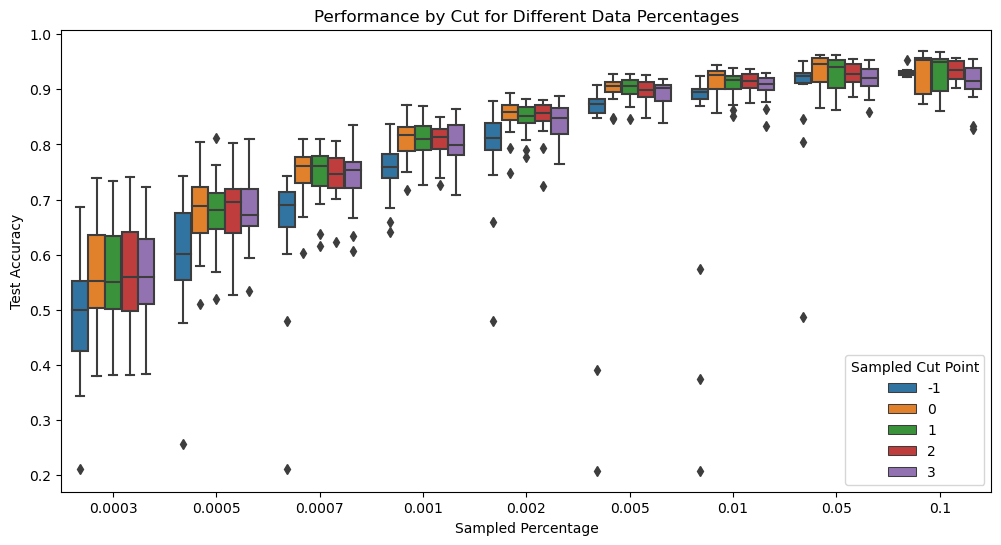

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combining both datasets for comparative analysis
df_combined = pd.DataFrame(results)

# Creating boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(x='sampled_percentage', y='test_acc', hue='sampled_cut_point', data=df_combined)
plt.title('Performance by Cut for Different Data Percentages')
plt.xlabel('Sampled Percentage')
plt.ylabel('Test Accuracy')
plt.legend(title='Sampled Cut Point')
plt.show()

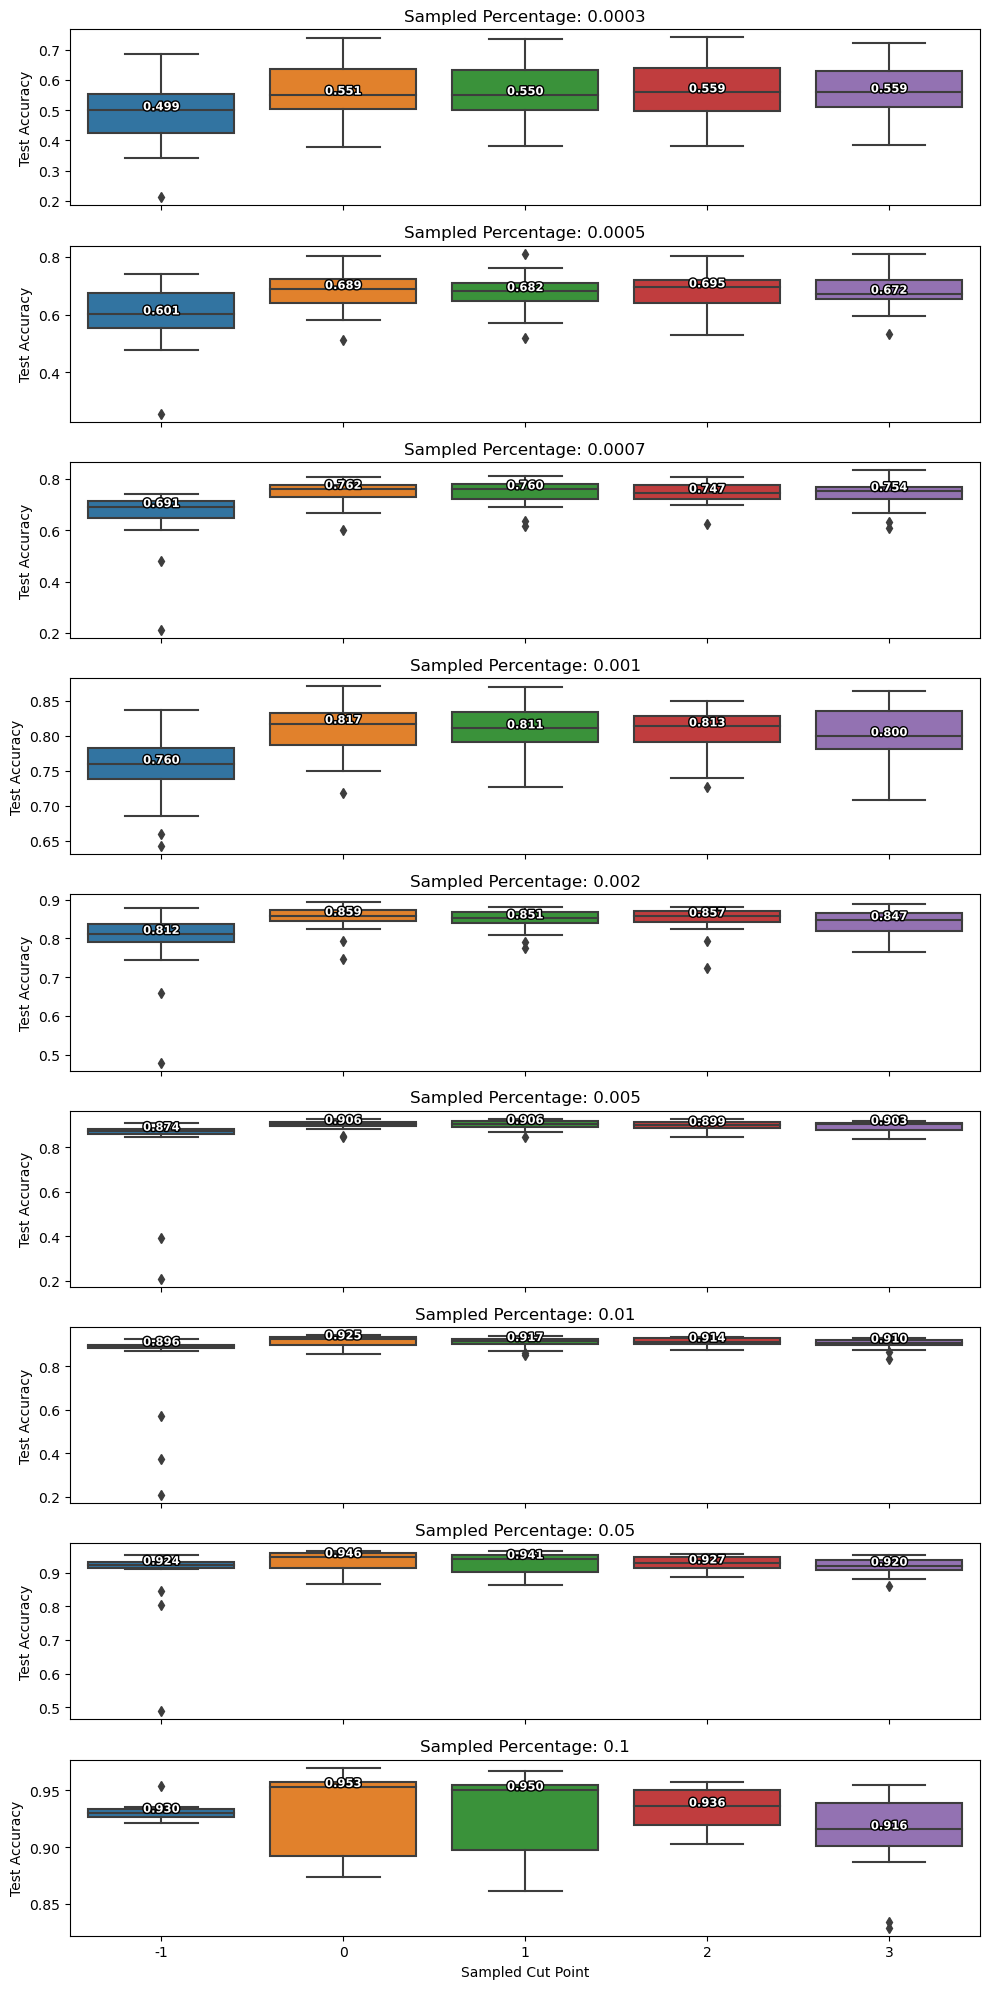

In [86]:
from matplotlib import patheffects

unique_percentages = df_combined['sampled_percentage'].unique()
#only 0.001 and 0.002
unique_percentages = [0.0003, 0.0005, 0.0007, 0.001, 0.002,0.005, 0.01, 0.05, 0.1]

n_percentages = len(unique_percentages)

# Adjusting the subplot layout for better readability of median values (improving contrast)
fig, axes = plt.subplots(nrows=n_percentages, ncols=1, figsize=(10, 20), sharex=True)

for i, percentage in enumerate(sorted(unique_percentages)):
    # Filtering data for each percentage
    df_subset = df_combined[df_combined['sampled_percentage'] == percentage]
    
    # Creating a boxplot for the current percentage
    sns.boxplot(x='sampled_cut_point', y='test_acc', data=df_subset, ax=axes[i])
    axes[i].set_title(f'Sampled Percentage: {percentage}')
    axes[i].set_xlabel('Sampled Cut Point')
    if i == n_percentages - 1:
        axes[i].set_xlabel('Sampled Cut Point')
    else:
        axes[i].set_xlabel('')
    axes[i].set_ylabel('Test Accuracy')

    # Annotating each boxplot with the median value and adjusting for better contrast
    medians = df_subset.groupby(['sampled_cut_point'])['test_acc'].median().sort_index()
    for j, median in enumerate(medians):
        text = axes[i].text(j, median, f'{median:.3f}', 
                            horizontalalignment='center', size='small', color='white', weight='semibold')
        text.set_path_effects([patheffects.withStroke(linewidth=2, foreground="black")])

plt.tight_layout()
plt.show()


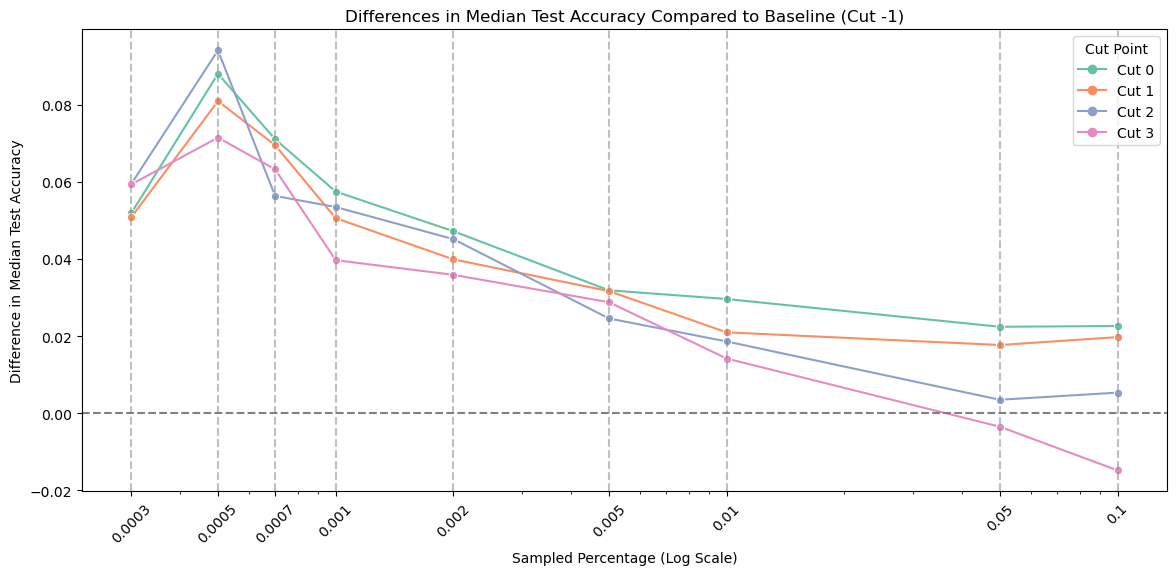

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_combined is your original DataFrame

# Grouping by sampled_percentage, sampled_cut_point and calculating medians
medians_by_cut = df_combined.groupby(['sampled_percentage', 'sampled_cut_point'])['test_acc'].median().reset_index()

# Pivoting the table for easier calculation of differences
pivot_medians = medians_by_cut.pivot(index='sampled_percentage', columns='sampled_cut_point', values='test_acc')

# Calculating differences from baseline (cut -1)
pivot_medians['diff_cut_0'] = pivot_medians[0] - pivot_medians[-1]
pivot_medians['diff_cut_1'] = pivot_medians[1] - pivot_medians[-1]
pivot_medians['diff_cut_2'] = pivot_medians[2] - pivot_medians[-1]
pivot_medians['diff_cut_3'] = pivot_medians[3] - pivot_medians[-1]

# Resetting index to make 'sampled_percentage' a column
pivot_medians.reset_index(inplace=True)

# Removing rows with NaN values
pivot_medians.dropna(subset=['diff_cut_0', 'diff_cut_1', 'diff_cut_2', 'diff_cut_3'], inplace=True)

# Adjusting the plot to use a logarithmic scale for the x-axis
plt.figure(figsize=(14, 6))

# Using a more harmonious color palette
palette = sns.color_palette("Set2", 4)  # A color palette with softer, more harmonious colors

# Plotting the differences for each cut
cut_columns = ['diff_cut_0', 'diff_cut_1', 'diff_cut_2', 'diff_cut_3']
for i, column in enumerate(cut_columns):
    sns.lineplot(x='sampled_percentage', y=column, data=pivot_medians, marker='o', color=palette[i])

plt.title('Differences in Median Test Accuracy Compared to Baseline (Cut -1)')
plt.xlabel('Sampled Percentage (Log Scale)')
plt.ylabel('Difference in Median Test Accuracy')
plt.axhline(0, color='gray', linestyle='--')  # Adding a line at zero for reference

# Adding vertical dashed lines for each sampled percentage
for percentage in pivot_medians['sampled_percentage'].unique():
    plt.axvline(percentage, color='gray', linestyle='--', alpha=0.5)

plt.xscale('log')  # Applying logarithmic scale to x-axis
plt.xticks(pivot_medians['sampled_percentage'], labels=pivot_medians['sampled_percentage'], rotation=45)  # Setting x-axis ticks

# Creating a custom legend that matches the line colors
legend_labels = ['Cut 0', 'Cut 1', 'Cut 2', 'Cut 3']
plt.legend(title='Cut Point', labels=legend_labels, handles=[plt.Line2D([0], [0], color=palette[i], marker='o') for i in range(len(cut_columns))])

plt.show()


In [88]:
median_baseline = df_combined[df_combined['sampled_cut_point'] == -1].groupby('sampled_percentage')['test_acc'].median()
df_with_baseline = df_combined.merge(median_baseline, on='sampled_percentage', suffixes=('', '_baseline'))
df_with_baseline['diff_to_baseline'] = df_with_baseline['test_acc'] - df_with_baseline['test_acc_baseline']
df_differences = df_with_baseline[df_with_baseline['sampled_cut_point'] != -1]

from scipy.stats import wilcoxon
import numpy as np

def perform_wilcoxon_test(data, baseline_median, cut_point):
    cut_data = data[data['sampled_cut_point'] == cut_point]['test_acc']
    baseline_data = np.full(len(cut_data), baseline_median)  # Creating an array of baseline values

    # Performing the Wilcoxon signed-rank test
    stat, p_value = wilcoxon(cut_data, baseline_data)
    return stat, p_value

# Performing the test for each cut point and sampled percentage
wilcoxon_corrected_results = []
for percentage in df_differences['sampled_percentage'].unique():
    baseline_median = median_baseline[percentage]
    for cut_point in df_differences[df_differences['sampled_cut_point'] != -1]['sampled_cut_point'].unique():
        subset = df_differences[(df_differences['sampled_percentage'] == percentage) & (df_differences['sampled_cut_point'] == cut_point)]
        stat, p_value = perform_wilcoxon_test(subset, baseline_median, cut_point)
        wilcoxon_corrected_results.append({
            'sampled_percentage': percentage,
            'sampled_cut_point': cut_point,
            'statistic': stat,
            'p_value': p_value
        })

# Converting the results to a DataFrame for easier visualization
df_wilcoxon_corrected = pd.DataFrame(wilcoxon_corrected_results)


In [89]:
# add a columns saying if the p-value is significant or not
df_wilcoxon_corrected['is_significant'] = df_wilcoxon_corrected['p_value'] < 0.05
#sort by sampled_percentage then by cut_point
df_wilcoxon_corrected = df_wilcoxon_corrected.sort_values(by=['sampled_percentage', 'sampled_cut_point'])
df_wilcoxon_corrected

,sampled_percentage,sampled_cut_point,statistic,p_value,is_significant
24,0.0003,0,45.0,0.023951,True
25,0.0003,1,49.0,0.036234,True
26,0.0003,2,36.0,0.008308,True
27,0.0003,3,38.0,0.010689,True
28,0.0005,0,14.0,0.000210,True
29,0.0005,1,13.0,0.000168,True
30,0.0005,2,8.0,0.000048,True
31,0.0005,3,12.0,0.000134,True
32,0.0007,0,21.0,0.000851,True
33,0.0007,1,18.0,0.000483,True


In [90]:
## compared to all baselines instead of the baseline median 

import pandas as pd
import numpy as np
from scipy.stats import wilcoxon

# Separating the baseline data
baseline_data = df_combined[df_combined['sampled_cut_point'] == -1]

# Separating the data for other cut points
df_differences = df_combined[df_combined['sampled_cut_point'] != -1]

def perform_wilcoxon_test(data, baseline_data, cut_point):
    cut_data = data[data['sampled_cut_point'] == cut_point]['test_acc']
    baseline_subset = baseline_data[baseline_data['sampled_percentage'] == data['sampled_percentage'].iloc[0]]['test_acc']
    
    # Make sure the lengths of both arrays are equal
    min_length = min(len(cut_data), len(baseline_subset))
    cut_data = cut_data.head(min_length)
    baseline_subset = baseline_subset.head(min_length)

    # Performing the Wilcoxon signed-rank test
    stat, p_value = wilcoxon(cut_data, baseline_subset)
    return stat, p_value

# Performing the test for each cut point and sampled percentage
wilcoxon_corrected_results = []
for percentage in df_differences['sampled_percentage'].unique():
    for cut_point in df_differences['sampled_cut_point'].unique():
        subset = df_differences[(df_differences['sampled_percentage'] == percentage) & (df_differences['sampled_cut_point'] == cut_point)]
        baseline_subset = baseline_data[baseline_data['sampled_percentage'] == percentage]
        if not baseline_subset.empty and not subset.empty:
            stat, p_value = perform_wilcoxon_test(subset, baseline_subset, cut_point)
            wilcoxon_corrected_results.append({
                'sampled_percentage': percentage,
                'sampled_cut_point': cut_point,
                'statistic': stat,
                'p_value': p_value
            })

# Converting the results to a DataFrame for easier visualization
df_wilcoxon_corrected = pd.DataFrame(wilcoxon_corrected_results)
df_wilcoxon_corrected['is_significant'] = df_wilcoxon_corrected['p_value'] < 0.05
df_wilcoxon_corrected = df_wilcoxon_corrected.sort_values(by=['sampled_percentage', 'sampled_cut_point'])
df_wilcoxon_corrected


,sampled_percentage,sampled_cut_point,statistic,p_value,is_significant
24,0.0003,0,30.0,0.003654,True
25,0.0003,1,30.0,0.003654,True
26,0.0003,2,24.0,0.001432,True
27,0.0003,3,24.0,0.001432,True
28,0.0005,0,7.0,0.000036,True
29,0.0005,1,2.0,0.000006,True
30,0.0005,2,0.0,0.000002,True
31,0.0005,3,3.0,0.000010,True
32,0.0007,0,0.0,0.000002,True
33,0.0007,1,0.0,0.000002,True


In [ ]:
# save fine-tuning results
params_tmp = copy.deepcopy(params)
del params_tmp["device"]
params_tmp["activation_function"] = str(params_tmp["activation_function"])
results = [params_tmp] + results

with open(f'results_jsons/results_freeze_{params["freeze"]}_reinit_{params["reinit"]}_pool_{params["use_pooling"]}_lr_{params["lr_fine_tune"]}.json', 'w') as f:
    json.dump(results, f)